In [1]:
%autoreload 2
from plasmapy import simulation
import astropy.units as u
import numpy as np

In [2]:
import xarray

In [3]:
from plasmapy.classes.sources.interparticle import InterParticleForces

In [4]:
eq_distance = 0.1
forces = {key: InterParticleForces(key, 100, eq_distance, 1, 100000, 4) for key in ('python', 'njit', 'njit_parallel')}

from collections import namedtuple
CustomParticle = namedtuple('custom_particle', ['mass', 'charge'])
particle = CustomParticle(mass=1 * u.dimensionless_unscaled, charge=1 * u.dimensionless_unscaled)

L = 1 * u.m
N = 32
np.random.seed(0)
x = u.Quantity(np.random.random((N, 3))*L,  u.m)
v = u.Quantity(np.zeros(x.shape, dtype=float), u.m / u.s)

from scipy import spatial
tree = spatial.cKDTree(x)
close_pairs = tree.query_pairs(eq_distance)
while close_pairs:
    for a, b in close_pairs:
        x[b] = np.random.random(3) * L
    tree = spatial.cKDTree(x)
    close_pairs = tree.query_pairs(eq_distance)

In [5]:
solutions = {engine: simulation.ParticleTracker(forces[engine], x, v, particle).run(1e-2 * u.s, dt = 1e-6 * u.s) for engine in ['njit']}

In [6]:
solutions['njit']

<xarray.Dataset>
Dimensions:           (dimension: 3, particle: 32, time: 1001)
Coordinates:
  * time              (time) float64 0.0 1.1e-05 2e-05 ... 0.009991 0.01
  * particle          (particle) int64 0 1 2 3 4 5 6 7 ... 25 26 27 28 29 30 31
  * dimension         (dimension) <U1 'x' 'y' 'z'
Data variables:
    position          (time, particle, dimension) float64 0.5488 ... 0.1883
    velocity          (time, particle, dimension) float64 0.000351 ... 3.15
    B                 (time, particle, dimension) float64 0.0 0.0 ... 0.0 0.0
    E                 (time, particle, dimension) float64 -702.1 ... 1.12e+04
    timestep          (time) float64 1e-06 1e-06 1e-06 ... 1e-06 1e-06 1e-06
    kinetic_energy    (time, particle) float64 8.078e-08 7.835e-08 ... 10.16
    potential_energy  (time, particle) float64 -17.09 -22.39 ... -130.2 -179.9
Attributes:
    particle:  custom_particle(mass=<Quantity 1.>, charge=<Quantity 1.>)

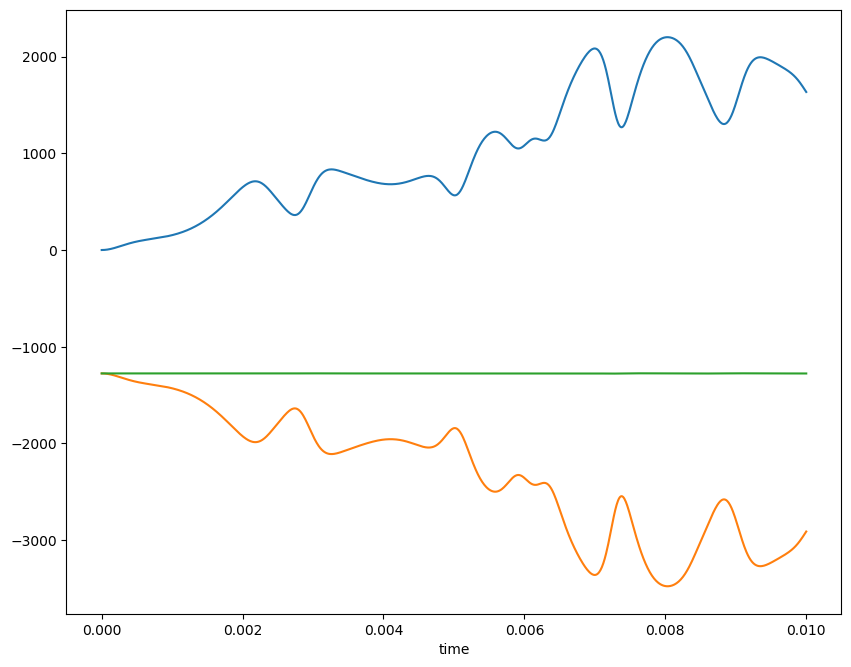

In [21]:
solutions['njit'].kinetic_energy.sum(dim='particle').plot.line()
solutions['njit'].potential_energy.sum(dim='particle').plot.line()
(solutions['njit'].potential_energy + solutions['njit'].kinetic_energy).sum(dim='particle').plot.line()

In [8]:
N_bins = 100
N_times = 1000
for solution in solutions.values():
    density = N / L ** 3

    from scipy import spatial

    import tqdm.auto as tqdm

    all_histograms = []
    max_L = L
    bins, dx = np.linspace(0, max_L, N_bins, endpoint=True, retstep=True)
    our_times = solution.time[np.linspace(0, solution.time.size, N_times, endpoint=False, dtype=int)]
    spatial_bins = (bins[1:] + bins[:-1] )/2
    for time in tqdm.tqdm(our_times):
        pos = solution.position.sel(time=time)
        tree = spatial.cKDTree(pos)

        histograms = []
        for particle in range(N):
            distances, indices = tree.query(pos.sel(particle=particle), range(2, N))
            hist, final_bins = np.histogram(distances, bins)
            rdf = hist / (4 * np.pi * dx * density)
            histograms.append(rdf)
        all_histograms.append(histograms)


    
    da = xarray.DataArray(all_histograms,
                          dims=('time', 'particle', 'spatial_bins'),
                          coords = {'time': our_times, 'spatial_bins': spatial_bins, 'particle': solution.particle})
#     solution.coords['spatial_bins'] = spatial_bins

#     solution['rdf'] = (('time', 'particle', 'spatial_bins'), np.array(all_histograms))

#     solution.rdf.mean(dim='particle').isel(time=-3).plot.line()


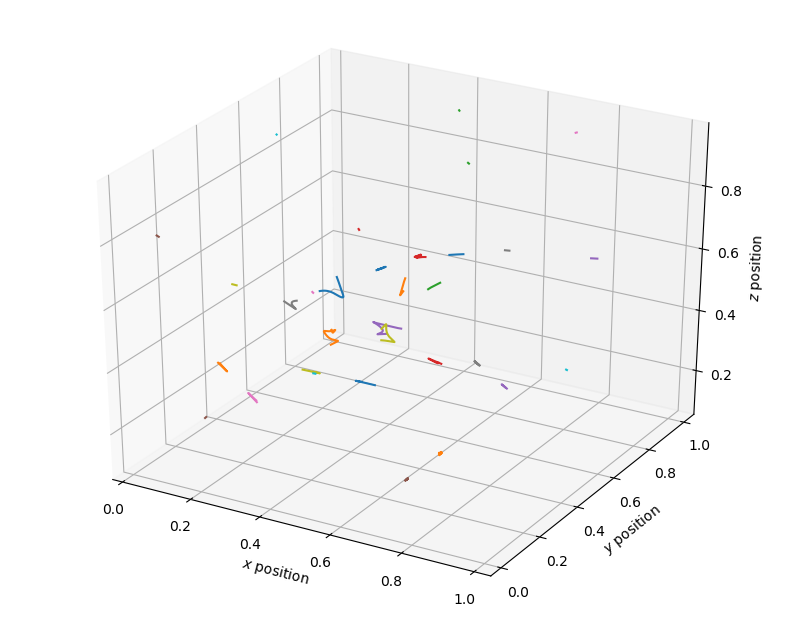

In [9]:
solution.particletracker.plot_trajectories()

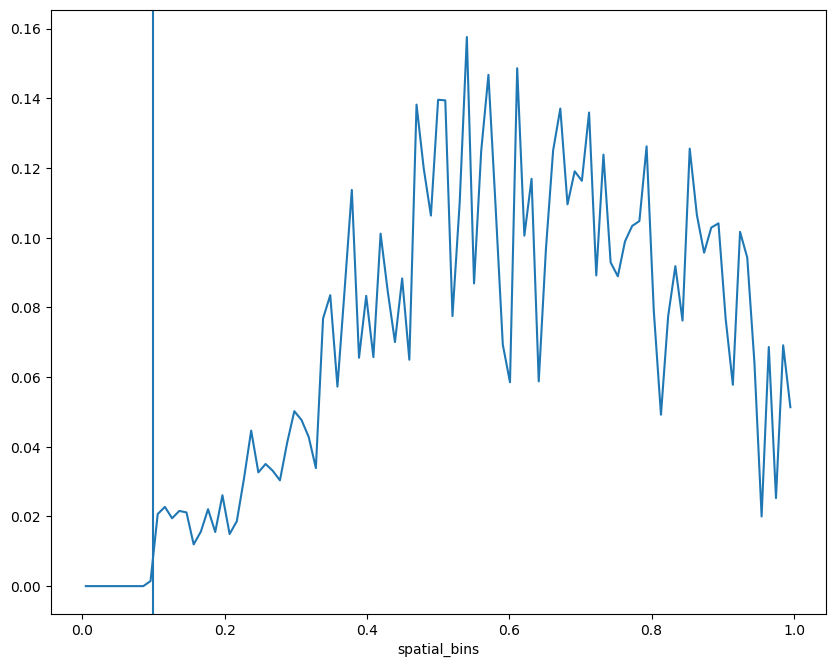

In [10]:
import matplotlib.pyplot as plt

da.isel(time=range(50, 1000)).mean(dim=['particle', 'time']).plot.line()
plt.axvline(eq_distance)

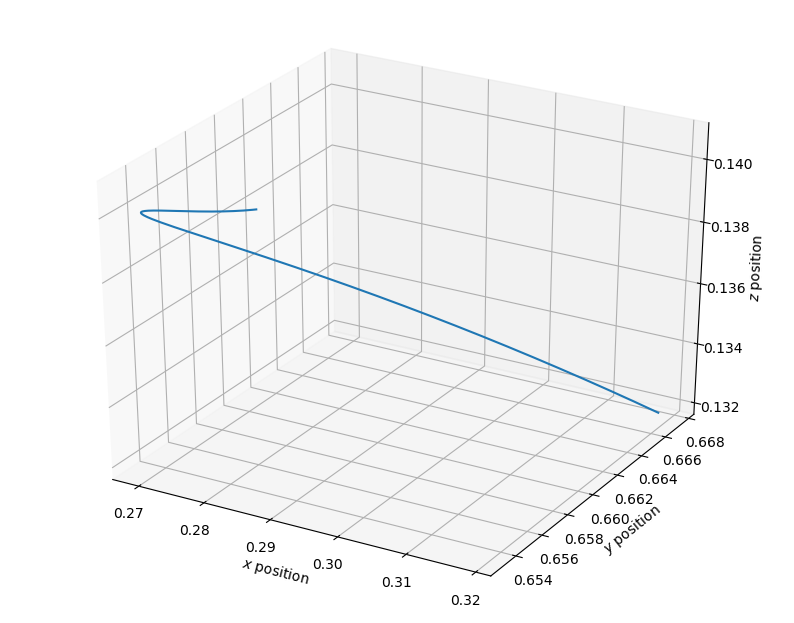

In [11]:
solution.sel(particle=[30]).particletracker.plot_trajectories()

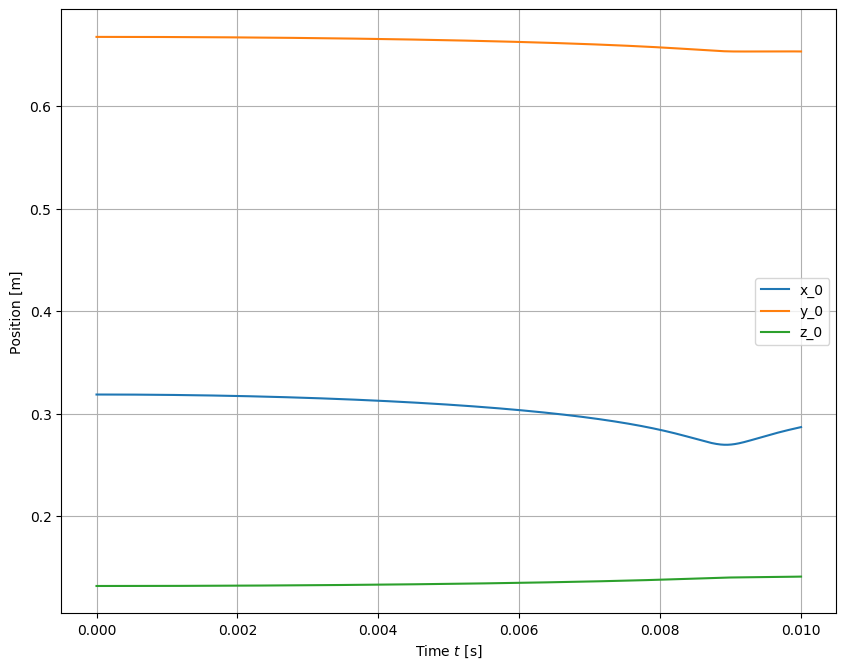

In [12]:
solution.sel(particle = [30]).particletracker.plot_time_trajectories()

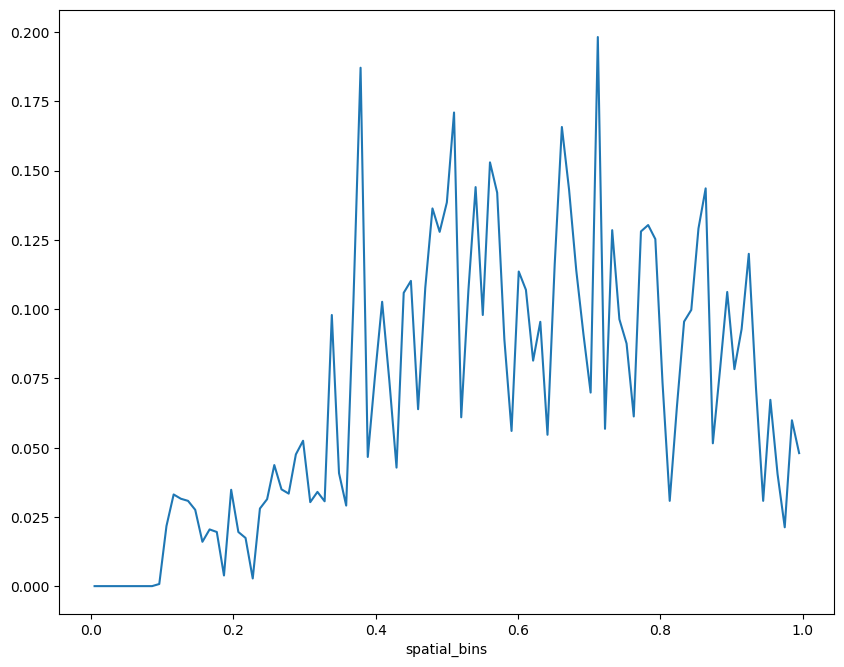

In [13]:
da.isel(time=range(900, 1000)).mean(dim=['particle', 'time']).plot.line()

In [14]:
np.array(all_histograms).shape

(1000, 32, 99)

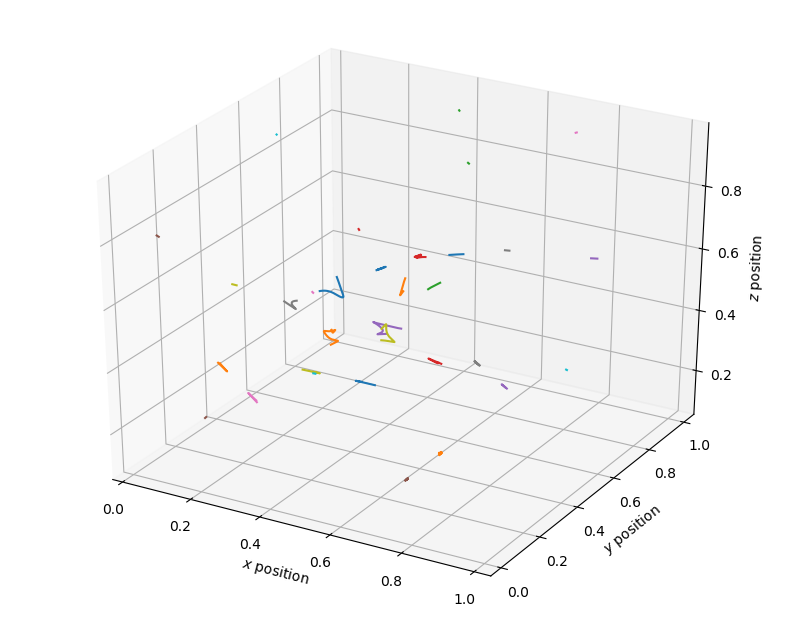

In [15]:
solution.particletracker.plot_trajectories()

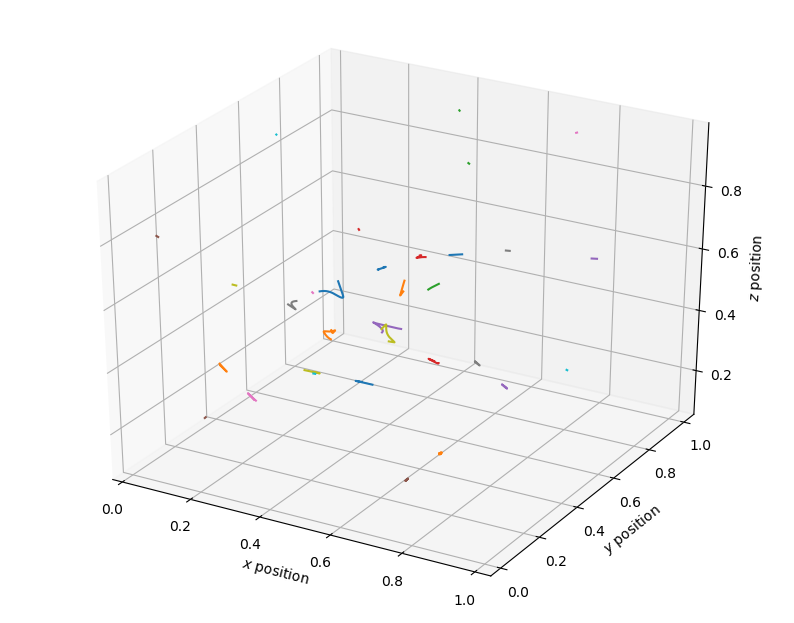

In [16]:
solution.isel(time=range(solution.time.size//10 * 4, solution.time.size // 10 * 10)).particletracker.plot_trajectories()

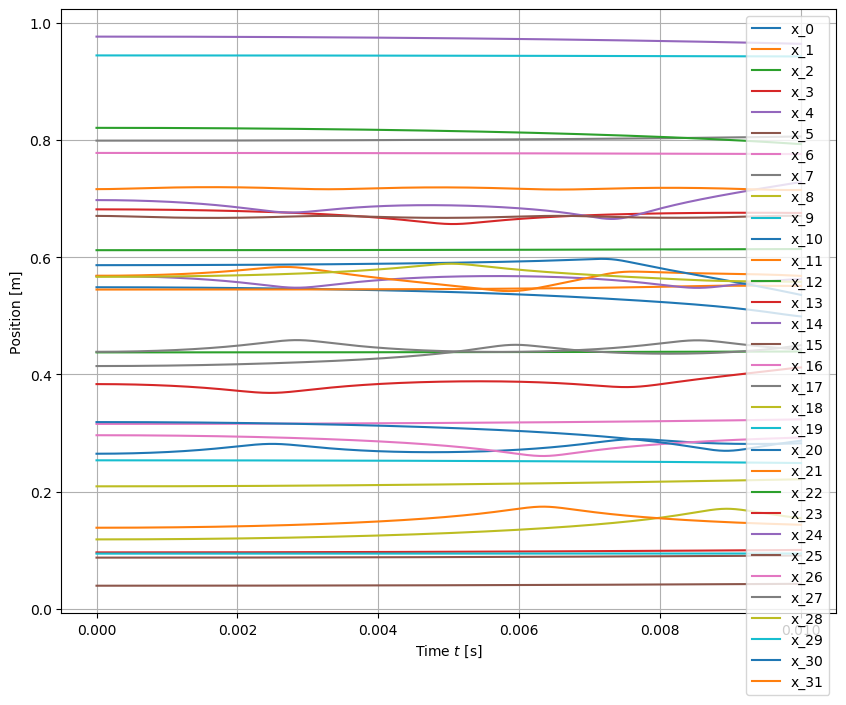

In [17]:
solution.particletracker.plot_time_trajectories('x')

In [18]:
solutions

{'njit': <xarray.Dataset>
 Dimensions:           (dimension: 3, particle: 32, time: 1001)
 Coordinates:
   * time              (time) float64 0.0 1.1e-05 2e-05 ... 0.009991 0.01
   * particle          (particle) int64 0 1 2 3 4 5 6 7 ... 25 26 27 28 29 30 31
   * dimension         (dimension) <U1 'x' 'y' 'z'
 Data variables:
     position          (time, particle, dimension) float64 0.5488 ... 0.1883
     velocity          (time, particle, dimension) float64 0.000351 ... 3.15
     B                 (time, particle, dimension) float64 0.0 0.0 ... 0.0 0.0
     E                 (time, particle, dimension) float64 -702.1 ... 1.12e+04
     timestep          (time) float64 1e-06 1e-06 1e-06 ... 1e-06 1e-06 1e-06
     kinetic_energy    (time, particle) float64 8.078e-08 7.835e-08 ... 10.16
     potential_energy  (time, particle) float64 -17.09 -22.39 ... -130.2 -179.9
 Attributes:
     particle:  custom_particle(mass=<Quantity 1.>, charge=<Quantity 1.>)}

In [19]:
solution = solutions['njit']
import pyvista
fig = pyvista.PlotterITK()
for particle in range(N):
    solution.particletracker.visualize(fig, particle=particle, stride=10);
fig.add_mesh(pyvista.Cube(bounds=(0, L.si.value, 0, L.si.value, 0, L.si.value)), opacity=0.1)
fig.show()

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…